# Travelling Wave

This is notebook is a bonus, you will not find it in in the paper :)

It just shows you how to initialize a standing or a travelling wave in the sheet model. 

We initially thought of using this for the Landau Damping diagnostic but ended up using the self-consistent modes generated inside the plasma.

In [1]:
import os
import sys
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm

sys.path.append('../../')
from sheet_model.synchronous import SyncSheetModel
from sheet_model.utils import get_mode_info, get_mode_initial_conditions, \
                              get_Efield, get_kEfield, get_x_eq, get_dx_eq

## $v_{th} = 0$

In [2]:
# ----------------------------------
# Sheet model Simulation Options

opt = {
    'n_guards' : 5, # number of guards
    'n_sheets' : 1000, #number of sheets
    'dt' : 1e-2, # simulation dt [1/w_p]
    'boundary' : 'periodic', # type (periodic or reflecting)
    'n_it_crossings' : 2, # number of iterations used to solve crossings
    'track_sheets': True,
    'L': 1
}

t_max = 10
dt_undersample = 1
dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])

In [3]:
# thermal velocity
v_th = 0 # [dx_eq w_p]

# mode to excite
mode = 20

# mode params
mode_info = get_mode_info(mode, n_sheets=opt['n_sheets'], v_th=v_th)

# a warning will be printed since v_th=0, ignore
print(f'lambda: {mode_info["lambda"]:0.1f} [dx_eq]')
print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')
print(f'w/w_p: {mode_info["w"]:0.1f}')
print(f'1/gamma', 1/mode_info["gamma"])

lambda: 100.0 [dx_eq]
v_ph/v_th: inf
w/w_p: 1.0
1/gamma nan


/home/dcarvalho/dawgnnson-sheet-model/notebooks/examples/../../sheet_model/utils.py:175: RuntimeWarning: divide by zero encountered in scalar divide
  -1
/home/dcarvalho/dawgnnson-sheet-model/notebooks/examples/../../sheet_model/utils.py:179: RuntimeWarning: divide by zero encountered in scalar divide
  * np.exp(-(v_ph**2) / (2 * v_th**2))
/home/dcarvalho/dawgnnson-sheet-model/notebooks/examples/../../sheet_model/utils.py:175: RuntimeWarning: invalid value encountered in scalar multiply
  -1
/tmp/ipykernel_153124/2021889845.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')


### Standing Wave

In [4]:
delta_nmax = 0.01
X0, _, x_eq0 = get_mode_initial_conditions(delta_nmax, mode_info)
V0 = np.zeros(opt['n_sheets']) # needed for standing wave

sim = SyncSheetModel(**opt)

# run simulation
X, V, X_eq, E = sim.run_simulation(x_0=X0,
                                   v_0=V0,
                                   x_eq_0=x_eq0,
                                   t_max=t_max,
                                   dt_undersample=dt_undersample,
                                   verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

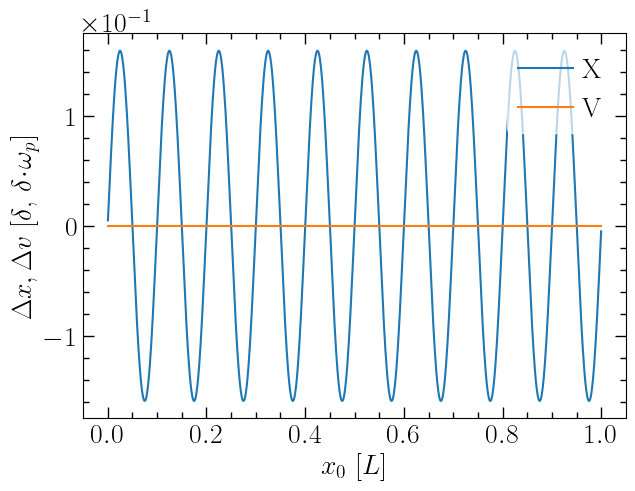

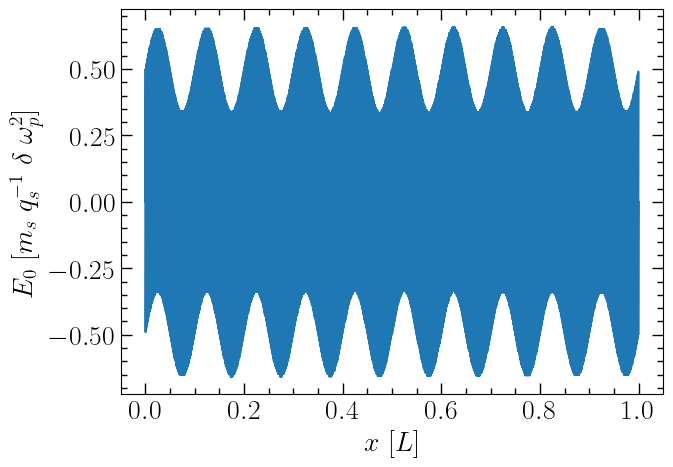

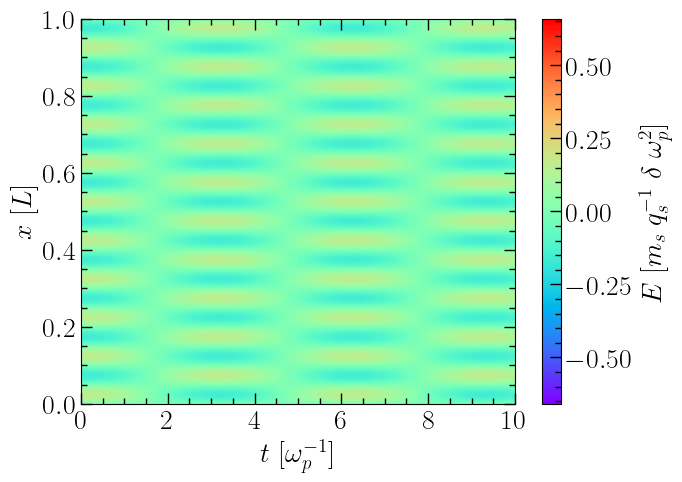

In [5]:
plt.figure()
plt.plot(x_eq0, (X0 - x_eq0)/dx_eq, label='X')
plt.plot(x_eq0, V0/dx_eq, label='V')
plt.ylabel('$\Delta x,\Delta v$ [$\delta$, $\delta\!\cdot\!\omega_p$]')
plt.xlabel('$x_0$ [$L$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()

Ef = np.array([get_Efield(X[i], 100000, dx_eq)[-1] for i in np.linspace(0,len(X)-1,40, dtype=np.int64)])

plt.figure()
plt.plot(np.linspace(0, 1, len(Ef[0])), Ef[0])
plt.ylabel('$E_0$ $[m_s \ q_s^{-1}\ \delta \ \omega_p^2]$')
plt.xlabel('$x$ [$L$]')

plt.figure()
plt.imshow((Ef - np.mean(Ef, axis=1).reshape(-1,1)).T , 
           extent=[0, t_max, 0,1], aspect='auto', cmap='rainbow',
           origin='lower')

plt.xlabel('$t$ $[\omega_p^{-1}]$')
plt.ylabel('$x$ $[L]$')
cbar = plt.colorbar()
cbar.ax.set_ylabel('$E$ [$m_s \ q_s^{-1}\ \delta \ \omega_p^2$]')
plt.show()

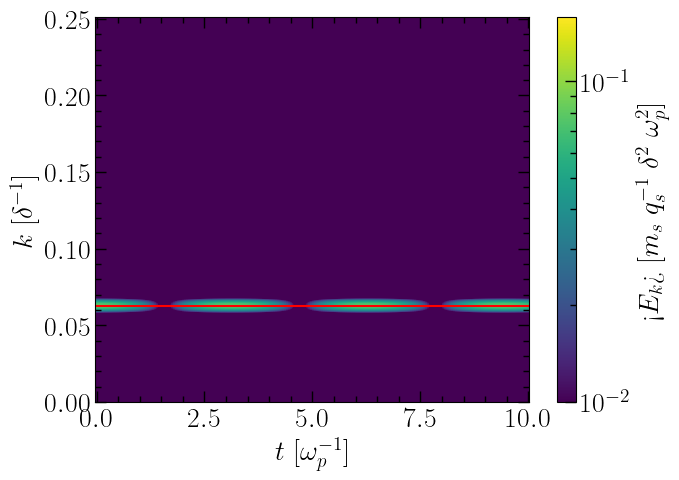

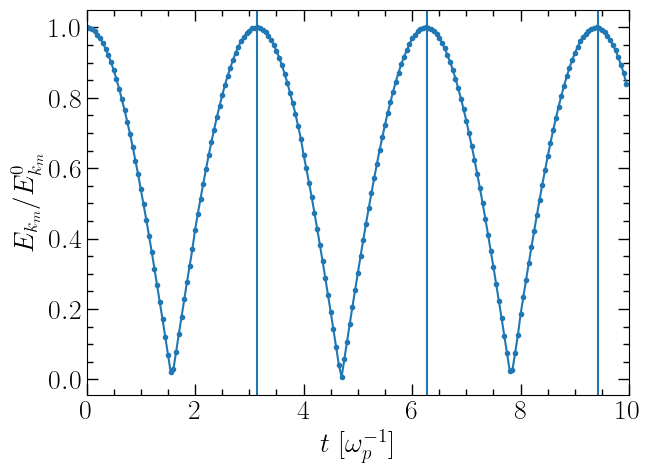

In [6]:
nt = 200
nx = 100000

dt = t_max / nt
t = np.arange(0, t_max, dt)

k, _ = get_kEfield(X[0], nx, dx_eq)
kEf = np.array([get_kEfield(X[i], nx , dx_eq)[-1] for i in np.linspace(0,len(X)-1, nt, dtype=np.int64)])

ik = np.argmin(np.abs(k - mode_info['k']))

plt.figure()
plt.imshow(kEf.T, 
           extent=[0 - dt/2, t_max + dt/2, k[-1] + k[1]/2.,  k[0] - k[1]/2.], 
           aspect='auto', 
           norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=np.max(kEf)))

plt.axhline(mode_info['k'], color='r')
plt.ylim(0,4*mode_info['k'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('<$E_k$> [$m_s \ q_s^{-1}\ \delta^2 \ \omega_p^2$]')
plt.xlabel('$t$ [$\omega_p^{-1}$]')
plt.ylabel('$k$ [$\delta^{-1}$]')

plt.figure()
plt.plot(t, kEf[:,ik]/kEf[0,ik], '.-')
plt.xlabel('$t$ [$\omega_p^{-1}$]')
plt.ylabel('$E_{k_m}/E_{k_m}^0$')
plt.xlim(0,t_max)
plt.axvline(mode_info['lambda']/mode_info['v_ph']/2)
plt.axvline(mode_info['lambda']/mode_info['v_ph'])
plt.axvline(3/2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(5/2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(3*mode_info['lambda']/mode_info['v_ph'])
plt.show()

### Traveling Wave

In [7]:
delta_nmax = 0.01
X0, V0, x_eq0 = get_mode_initial_conditions(delta_nmax, mode_info)

# run simulation
X, V, X_eq, E = sim.run_simulation(x_0=X0,
                                   v_0=V0,
                                   x_eq_0=x_eq,
                                   t_max=t_max,
                                   dt_undersample=dt_undersample,
                                   verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

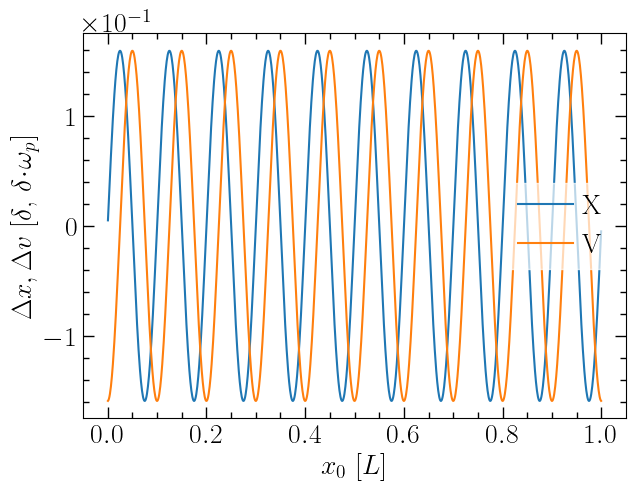

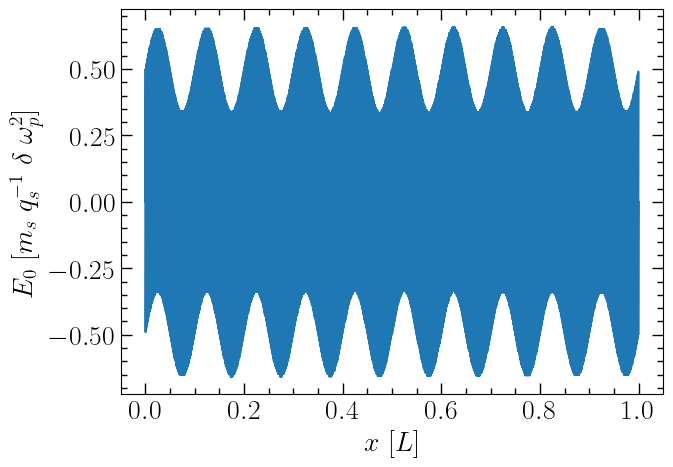

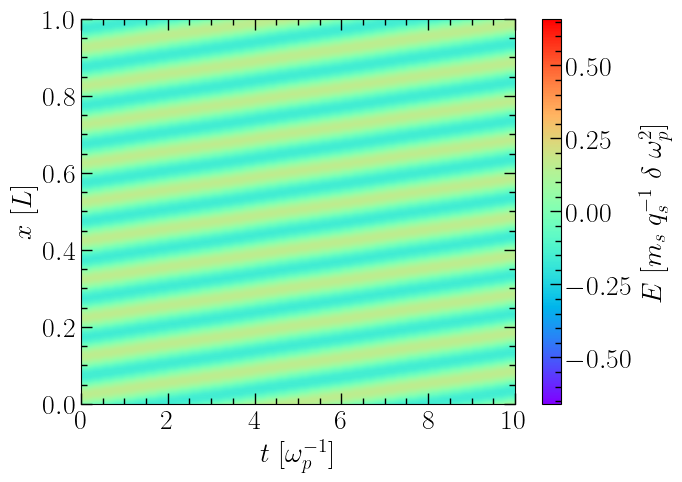

In [8]:
plt.figure()
plt.plot(x_eq0, (X0 - x_eq0)/dx_eq, label='X')
plt.plot(x_eq0, V0/dx_eq, label='V')
plt.ylabel('$\Delta x,\Delta v$ [$\delta$, $\delta\!\cdot\!\omega_p$]')
plt.xlabel('$x_0$ [$L$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()

Ef = np.array([get_Efield(X[i], 100000, dx_eq)[-1] for i in np.linspace(0,len(X)-1,40, dtype=np.int64)])

plt.figure()
plt.plot(np.linspace(0, 1, len(Ef[0])), Ef[0])
plt.ylabel('$E_0$ $[m_s \ q_s^{-1}\ \delta \ \omega_p^2]$')
plt.xlabel('$x$ [$L$]')

plt.figure()
plt.imshow((Ef - np.mean(Ef, axis=1).reshape(-1,1)).T , 
           extent=[0, t_max, 0,1], aspect='auto', cmap='rainbow',
           origin='lower')

plt.xlabel('$t$ $[\omega_p^{-1}]$')
plt.ylabel('$x$ $[L]$')
cbar = plt.colorbar()
cbar.ax.set_ylabel('$E$ [$m_s \ q_s^{-1}\ \delta \ \omega_p^2$]')
plt.show()

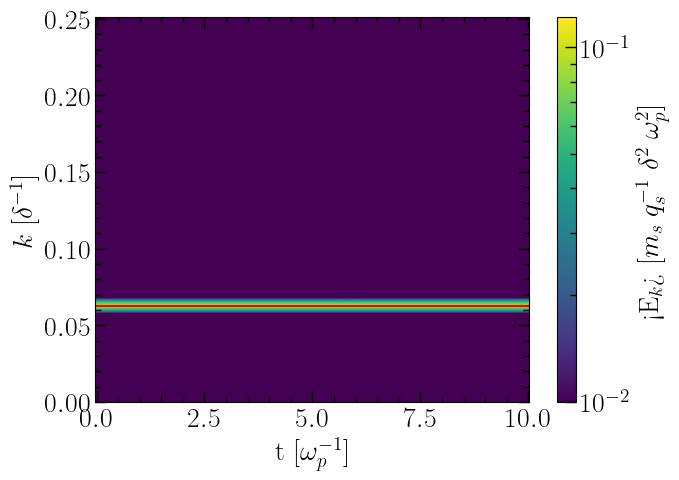

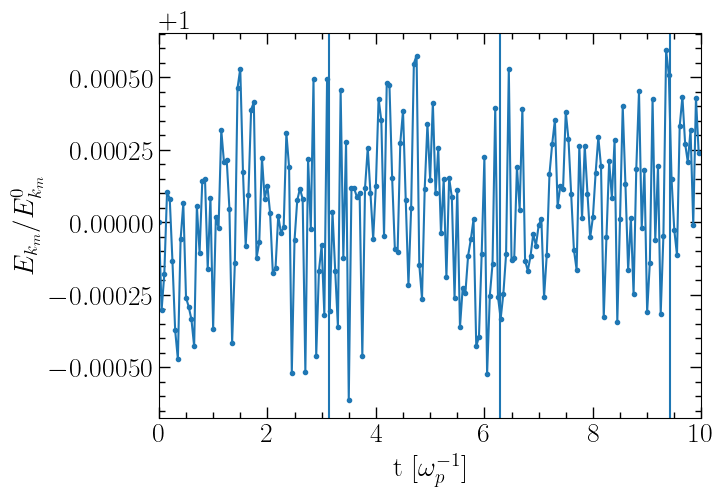

In [9]:
nt = 200
nx = 100000

dt = t_max / nt
t = np.arange(0, t_max, dt)

k, _ = get_kEfield(X[0], nx, dx_eq)
kEf = np.array([get_kEfield(X[i], nx , dx_eq)[-1] for i in np.linspace(0,len(X)-1, nt, dtype=np.int64)])

ik = np.argmin(np.abs(k - mode_info['k']))

plt.figure()
plt.imshow(kEf.T, 
           extent=[0 - dt/2, t_max + dt/2, k[-1] + k[1]/2.,  k[0] - k[1]/2.], 
           aspect='auto', 
           norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=np.max(kEf)))

plt.axhline(mode_info['k'], color='r')
plt.ylim(0,4*mode_info['k'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('<E$_k$> [$m_s \ q_s^{-1}\ \delta^2 \ \omega_p^2$]')
plt.xlabel('t [$\omega_p^{-1}$]')
plt.ylabel('$k$ [$\delta^{-1}$]')

plt.figure()
plt.plot(t, kEf[:,ik]/kEf[0,ik], '.-')
plt.xlabel('t [$\omega_p^{-1}$]')
plt.ylabel('$E_{k_m}/E_{k_m}^0$')
plt.xlim(0,t_max)
plt.axvline(mode_info['lambda']/mode_info['v_ph']/2)
plt.axvline(mode_info['lambda']/mode_info['v_ph'])
plt.axvline(3/2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(5/2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(3*mode_info['lambda']/mode_info['v_ph'])
plt.show()

## $v_{th} \neq 0$

### Traveling Wave

In [10]:
# ----------------------------------
# Sheet model Simulation Options
opt = {
    'n_guards' : 5, # number of guards
    'n_sheets' : 3000, #number of sheets
    'dt' : 1e-2, # simulation dt [1/w_p]
    'boundary' : 'reflecting', # type (periodic or reflecting)
    'n_it_crossings' : 2, # number of iterations used to solve crossings
    'track_sheets': True,
    'L': 1
}

t_max = 30
dt_undersample = 1

dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])

In [11]:
# thermal velocity
v_th = 3 # [dx_eq w_p]
# mode to excite
mode = 5

# mode params
mode_info = get_mode_info(mode, n_sheets=opt['n_sheets'], v_th=v_th)

print(f'lambda: {mode_info["lambda"]:0.1f} [dx_eq]')
print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')
print(f'w/w_p: {mode_info["w"]:0.1f}')
print(f'1/gamma', 1/mode_info["gamma"])
print(f'gamma/sqrt(k)', -mode_info["gamma"]/np.sqrt(mode_info["k"]))

lambda: 1200.0 [dx_eq]
v_ph/v_th: 63.7
w/w_p: 1.0
1/gamma -inf
gamma/sqrt(k) 0.0


/tmp/ipykernel_153124/2368927875.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'1/gamma', 1/mode_info["gamma"])


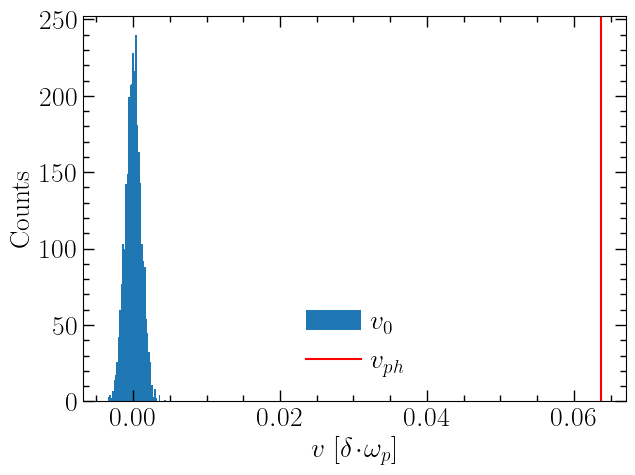

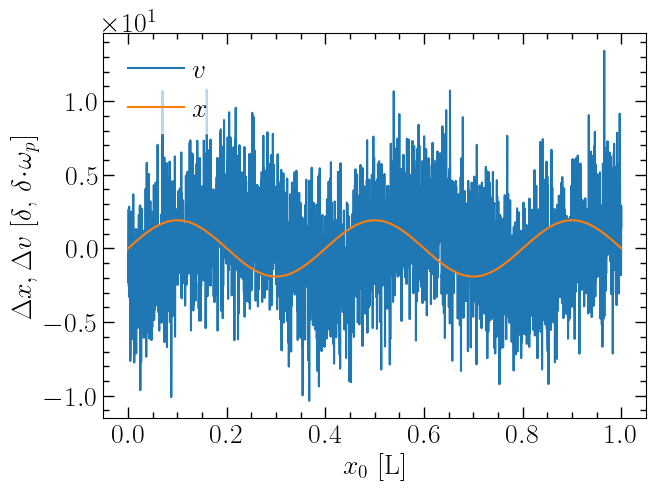

In [12]:
delta_nmax = 0.01
np.random.seed(42)
X0, V0, x_eq0 = X0, V0, x_eq0 = get_mode_initial_conditions(delta_nmax, mode_info)
V0 += np.random.normal(0, v_th, opt['n_sheets']) * dx_eq

plt.figure()
plt.hist(V0, bins=40, label='$v_0$')
plt.axvline(mode_info['v_ph']*dx_eq, c='red', label='$v_{ph}$')
plt.xlabel('$v$ $[\delta\!\cdot\!\omega_p]$')
plt.ylabel('Counts')
plt.legend()

plt.figure()
plt.plot(x_eq0, V0/dx_eq, label='$v$')
plt.plot(x_eq0, (X0 - x_eq0)/dx_eq, label='$x$')
plt.ylabel('$\Delta x,\Delta v$ [$\delta$, $\delta\!\cdot\!\omega_p$]')
plt.xlabel('$x_0$ [L]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()

In [13]:
# run simulation
sim = SyncSheetModel(**opt)

X, V, X_eq, E = sim.run_simulation(x_0=X0,
                                   v_0=V0,
                                   x_eq_0=x_eq0,
                                   t_max=t_max,
                                   dt_undersample=dt_undersample,
                                   verbose=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

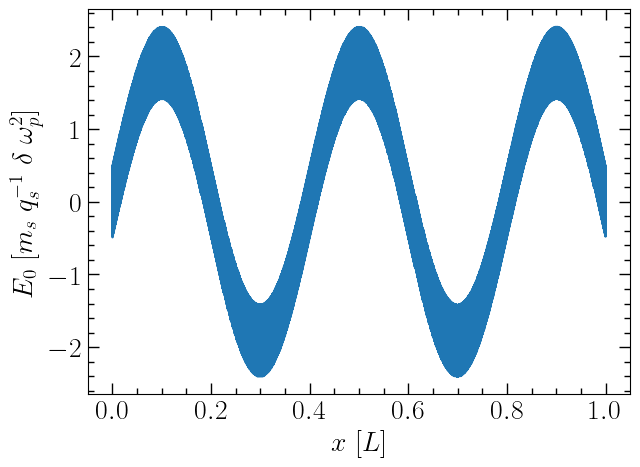

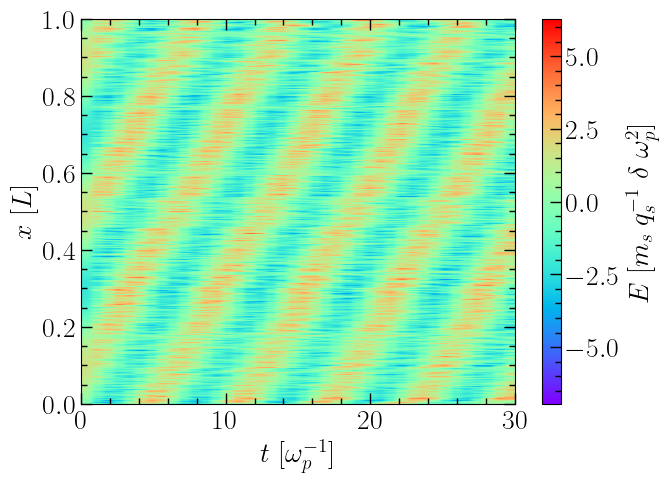

In [14]:
Ef = np.array([get_Efield(X[i], 100000, dx_eq)[-1] for i in np.linspace(0,len(X)-1,40, dtype=np.int64)])

plt.figure()
plt.plot(np.linspace(0, 1, len(Ef[0])), Ef[0])
plt.ylabel('$E_0$ $[m_s \ q_s^{-1}\ \delta \ \omega_p^2]$')
plt.xlabel('$x$ $[L]$')

plt.figure()
plt.imshow((Ef - np.mean(Ef, axis=1).reshape(-1,1)).T , 
           extent=[0, t_max, 0,1], aspect='auto', cmap='rainbow',
           origin='lower')

plt.xlabel('$t$ $[\omega_p^{-1}]$')
plt.ylabel('$x$ $[L]$')
cbar = plt.colorbar()
cbar.ax.set_ylabel('$E$ [$m_s \ q_s^{-1}\ \delta \ \omega_p^2$]')
plt.show()

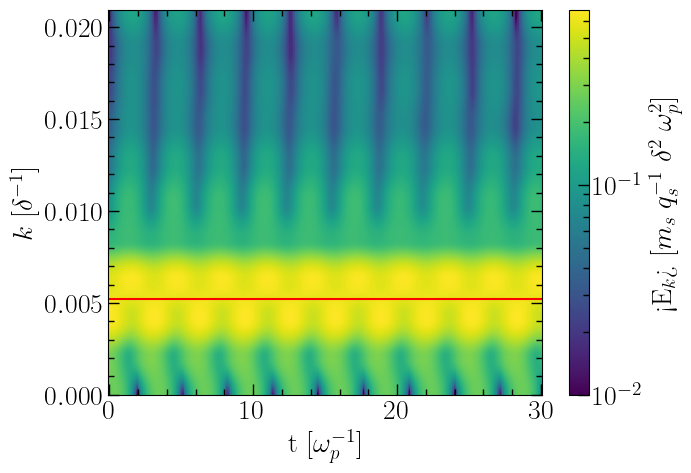

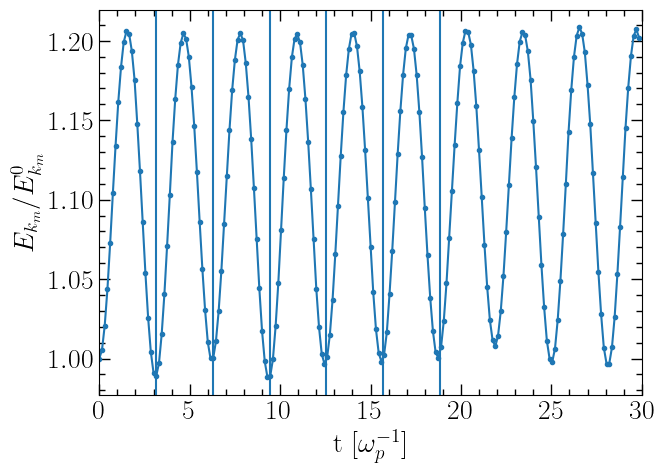

In [15]:
nt = 200
nx = 100000

dt = t_max / nt
t = np.arange(0, t_max, dt)

k, _ = get_kEfield(X[0], nx, dx_eq)
kEf = np.array([get_kEfield(X[i], nx , dx_eq)[-1] for i in np.linspace(0,len(X)-1, nt, dtype=np.int64)])

ik = np.argmin(np.abs(k - mode_info['k']))

plt.figure()
plt.imshow(kEf.T, 
           extent=[0 - dt/2, t_max + dt/2, k[-1] + k[1]/2.,  k[0] - k[1]/2.], 
           aspect='auto', 
           norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=np.max(kEf)))

plt.axhline(mode_info['k'], color='r')
plt.ylim(0,4*mode_info['k'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('<E$_k$> [$m_s \ q_s^{-1}\ \delta^2 \ \omega_p^2$]')
plt.xlabel('t [$\omega_p^{-1}$]')
plt.ylabel('$k$ [$\delta^{-1}$]')

plt.figure()
plt.plot(t, kEf[:,ik]/kEf[0,ik], '.-')
plt.xlabel('t [$\omega_p^{-1}$]')
plt.ylabel('$E_{k_m}/E_{k_m}^0$')
plt.xlim(0,t_max)
plt.axvline(mode_info['lambda']/mode_info['v_ph']/2)
plt.axvline(mode_info['lambda']/mode_info['v_ph'])
plt.axvline(3/2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(5/2*mode_info['lambda']/mode_info['v_ph'])
plt.axvline(3*mode_info['lambda']/mode_info['v_ph'])
plt.show()